Auto reload

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


import statements

In [7]:

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision as vision
from torchvision import transforms
import torch.nn as nn

from data import ChristmasImages
from my_first_model import Network

from torch.utils import data

Data loader

In [8]:
training_set_path = '/Users/andrewkirubsingh/Desktop/Deeplearning/Challenge/train'
validation_set_path = '/Users/andrewkirubsingh/Desktop/Deeplearning/Challenge/evaluation/dataset/data'
batch_size_train = 256

training_set = ChristmasImages(training_set_path)
validation_set = ChristmasImages(validation_set_path)

data_loader_train  = data.DataLoader(training_set, batch_size = batch_size_train, shuffle = True)
data_loader_val = data.DataLoader(validation_set, batch_size=10, shuffle=True)



Visualing the data loader

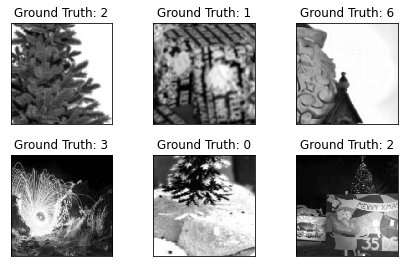

In [54]:
examples = enumerate(data_loader_train)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

Forward pass

In [19]:
network = Network()

Loss calculation

In [20]:
loss_fct = nn.CrossEntropyLoss()

Function for training

In [21]:
def train(epoch):
    network.train() # tells the network we are training now, affects behavior of dropout etc 
    for batch_idx, (data,target) in enumerate (data_loader_train):
        optimizer.zero_grad()
        output = network(data)
        loss = loss_fct(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader_train.dataset),
                100. * batch_idx / len(data_loader_train), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*batch_size_train) + ((epoch-1)*len(data_loader_train.dataset)))

Training

In [31]:
n_epochs = 1
learning_rate = 0.1
momentum = 0.9
log_interval = 10

network = Network()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)


train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/3726 (0%)]	Loss: 2.074111
Train Epoch: 1 [2560/3726 (67%)]	Loss: 1.916142


Saving the model's weitghts

In [32]:
network.save_model()

Inference

utils.py

In [25]:
import torch
from torch.utils.data import Dataset
import csv
from data import ChristmasImages


class TestSet(Dataset):
    
    def __init__(self, path):
        super().__init__()
        self.dataset = ChristmasImages(path + '/data/val', training=False)
        
        with open(path + '/val.csv') as file:
            reader = csv.reader(file)
            next(reader)
            labels = {}
            for row in reader:
                labels[int(row[0])] = int(row[1])
        self.labels = labels


        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        label = self.labels[idx]
        return image, label


def evaluate(model, loader):
    accuracy = 0.
    with torch.no_grad():
        for image, label in loader:
            _, prediction = model(image).max(dim=1)
            accuracy += (prediction == label).sum().item()
    
    accuracy /= len(loader)
    return accuracy*100


evaluate.py

In [26]:
import torch
from torch.utils.data import DataLoader
from my_first_model import Network


# dataset location
path = '/Users/andrewkirubsingh/Desktop/Deeplearning/Challenge/evaluation/dataset'

model = Network().eval()
model.load_state_dict(torch.load('model'))

loader = DataLoader(TestSet(path), batch_size=1)

examples = enumerate(loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
    output = model(example_data)
    
fig = plt.figure()
for i in range(1):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {} \n Ground Truth: {}".
              format(output.data.max(1, keepdim=True)[1][i].item(),example_targets.item()))

    plt.xticks([])
    plt.yticks([])
    

print(evaluate(model, loader))

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for fc1.weight: copying a param with shape torch.Size([50, 1280]) from checkpoint, the shape in current model is torch.Size([50, 2080]).